I believe that my implementation of the Lucy-Richardson deconvolution isn't perfect. This notebook is to test the effects.

In [13]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd
from DeconvolvePSF.lucy import convolve, convolveStar, makeGaussian, calcChi2#, deconvolve
from skimage.restoration import richardson_lucy as rl
from subprocess import check_output
from itertools import izip
import ipywidgets

import scipy
import numpy.lib.index_tricks as itricks
import pdb
from WavefrontPSF.psf_evaluator import Moment_Evaluator
#from scipy.signal import convolve2d as convolve
#from DeconvolvePSF.lucy import deconvolve

In [14]:
import DeconvolvePSF.colormaps as cmaps
plt.register_cmap(name='viridis', cmap=cmaps.viridis)
plt.set_cmap(cmaps.viridis)

In [15]:
# these give the deconvolved stars
out_base = '/nfs/slac/g/ki/ki18/des/swmclau2/DeconvOutput/'

dir_str = check_output('ls -d %s*/'%out_base, shell = True) #get all the directories in our output dir
dir_list = dir_str.split('/\n')[:-3]#skip the lsat one, its ''

expids = [int(direc.lstrip('%s'%out_base) ) for direc in dir_list]
expids = sorted(expids)
bad_expid_idxs = [2,5, 6]
#14
#5
#expid = expids[0]
expid = 149440
print(expid)

#out_base = '/nfs/slac/g/ki/ki18/des/cpd/DeconvOutput/'
deconv_dir = out_base + '{0:08d}'.format(expid)
# not sure what stars these really are? the combined psfex + deconv?
deconvmodel_loc = out_base + '{0:08d}/{0}_stars.npy'.format(expid)
deconvopt_loc = out_base + '{0:08d}/{0}_opt.npy'.format(expid)
deconvatm_loc = out_base + '{0:08d}/{0}_atm.npy'.format(expid)
deconvstarsminusopt_loc = out_base + '{0:08d}/{0}_stars_minus_opt.npy'.format(expid)
deconvdata_loc = out_base + '{0:08d}/{0}_data.npy'.format(expid)
deconvpsfex_loc = out_base + '{0:08d}/{0}_psfexalone.npy'.format(expid)
deconvdf_loc = out_base + '{0:08d}/results.h5'.format(expid)
deconvdf_key = 'table_{0:08d}'.format(expid)

deconvopt_immediate_loc = '/nfs/slac/g/ki/ki18/des/swmclau2/DeconvOutput/{0:08d}/{0}_opt_test.npy'.format(expid)

jamierod_results_path = '/nfs/slac/g/ki/ki18/des/cpd/jamierod_results.csv'
mesh_directory = '/nfs/slac/g/ki/ki22/roodman/ComboMeshesv20'
# directory containing the input data files
base_directory = '/nfs/slac/g/ki/ki18/des/cpd/psfex_catalogs/SVA1_FINALCUT/psfcat/'

149440


In [16]:
#Look I'm a comment this isn't rawnb
atmpsf = np.load(deconvatm_loc)
optpsf = np.load(deconvopt_loc)
starminusopt = np.load(deconvstarsminusopt_loc)
model = np.load(deconvmodel_loc)
psfexpsf = np.load(deconvpsfex_loc)
stars = np.load(deconvdata_loc)

stars[stars < -1000] = 0

df = pd.read_hdf(deconvdf_loc, deconvdf_key)

In [36]:
def deconvolve(PSF,phi_tilde,psi_0=None,mask=None,mu0=0.0,niterations=10,convergence=-1,chi2Level=0.0,extra=False):
    """ Implementation of the Richardson-Lucy deconvolution algorithm.
    Notation follows Lucy 1974, Eqn 15 and 14.  Add  noise term following
    Snyder et al 1993.
    Arguments
    ---------
    PSF          known Point Spread Function
    phi_tilde    measured object
    psi_0        starting guess for deconvolution
    mask         =0 for bins where we know that recovered image has no flux 
    mu0          background noise estimate
    """

    # normalize PSF
    PSF = PSF / np.sum(PSF)

    # if no initial guess, make one from 2nd moments of input image - PSF
    if psi_0 is None:
        '''
        # calculate Moments of psi_tilde and PSF, subtract and

        # calculate moments
        evaluator = Moment_Evaluator()

        # try a better starting guess - based on our knowledge of the PSF
        image_moments = evaluator(phi_tilde)
        PSF_moments = evaluator(PSF)

        #TODO what to do if makeGaussian throws an error?
        # subtract 2nd order moments in quadrature, use an object with the difference
        Mxx = image_moments['Mxx'][0] - PSF_moments['Mxx'][0]
        Myy = image_moments['Myy'][0] - PSF_moments['Myy'][0]
        Mxy = image_moments['Mxy'][0] - PSF_moments['Mxy'][0]

        psi_r = makeGaussian(phi_tilde.shape,Mxx,Myy,Mxy)
        #sometimes this fails if the observation is too non-gaussian
        if np.any(np.logical_or( np.isinf(psi_r), np.isnan(psi_r))):
            psi_r = phi_tilde #trying this out; otherwise we'll just have to raise errors/hell
        '''
        psi_r = np.ones(PSF.shape)
    else:
        # initial guess
        psi_r = np.abs(psi_0)

    # mask starting guess
    if mask is not None:    
        psi_r = psi_r * mask

    # normalize starting guess
    psi_r = psi_r / np.sum(psi_r)
    
    #TODO Maybe this should be an error instead of a warning.
    if np.any(np.isnan(psi_r)):
        raise RuntimeWarning("NaN in initial guess, skip this value. ")
                
    # mask image too
    if mask != None:
        phi_tilde = phi_tilde * mask
        
    # find normalization for measured image
    beta = np.sum(phi_tilde)
        
    # now iterate, either until convergence reached or fixed number of iterations are done
    psiByIter = []
    diffByIter = []
    chi2ByIter = []
    iteration = 0
    last_diff = np.inf
    continueTheLoop = True
    
    while continueTheLoop: 
        
        #plt.imshow(psi_r,interpolation = 'None', vmin = 0)
        #plt.show()
        
        # calculate next approximation to psi
        phi_r = beta*convolve(psi_r,PSF) + mu0
        psi_rplus1 = psi_r * convolveStar(beta*(phi_tilde)/phi_r,PSF)

        # mask the next iteration
        if mask != None:
            psi_rplus1 = psi_rplus1 * mask
        
        # normalize it
        psi_rplus1 = psi_rplus1 / np.sum(psi_rplus1)

        # check for convergence if desired
        #Why are the psiByIter appends inside the convergence test?
        if convergence>0:
            # compare psi_r and psi_rplus1
            psiByIter.append(psi_rplus1)
            diff = np.sum(np.abs(psi_rplus1 - psi_r))
            #print iteration, diff
            diffByIter.append(diff)
            if diff<convergence:
                continueTheLoop = False
            #elif diff > last_diff:
            #    psi_rplus1 = np.array(psi_r)
            #    continueTheLoop = False

        # also calculate how close to a solution we are
        chi2 = calcChi2(PSF,psi_rplus1,phi_tilde,beta,mu0)
        chi2ByIter.append(chi2)
        if 0<chi2<chi2Level:
            print 'Here', chi2
            #pass
            continueTheLoop = False
        
        # check for Chi2 level
                

        # always check number of iterations
        if iteration==niterations-1:
            continueTheLoop = False

        # save for next iteration
        iteration+=1     
        psi_r = np.array(psi_rplus1)  # does a deepcopy
        last_diff = diff

    #TODO rescale deconv by flux

    # we are done!
    if extra:
        return psi_rplus1,diffByIter,psiByIter,chi2ByIter
    else:
        
       
        return psi_rplus1  

In [37]:
from numpy.random import poisson
def plot_deconv(idx, alg = 'mine'):
      
    #norm_star = stars[idx]/np.sum(stars[idx])
    #norm_star = stars[idx]

    #background = norm_star[norm_star< norm_star.mean()+norm_star.std()]
    #print norm_star.mean(), norm_star.std()
    background = 0.005
    flux = 5000
    back = flux*background
    noise = poisson(lam = back, size = model[idx].shape)
    model_noisy = flux*model[idx] + noise
    mnt = model_noisy.sum()
    model_noisy = model_noisy/mnt
    background = model_noisy[model_noisy< model_noisy.mean()+model_noisy.std()]
    
    if alg == 'mine':
        resid = deconvolve(atmpsf[idx]/atmpsf[idx].sum(), model_noisy,psi_0=None,mask=None,mu0=background.mean(),convergence=1e-2,chi2Level=0.,niterations=50, extra= False)
    else: 
        resid = rl(atmpsf[idx], model_noisy, iterations = 50, clip = True)
        
    #resid_back = resid[resid< resid.mean() + 2*resid.std()]
    
    #resid-=resid_back.mean()
    #resid[resid<0] = 0
    
    #resid = resid/resid.sum()
        
    reconv = convolve(resid, atmpsf[idx]/atmpsf[idx].sum())
        
        
    evaluator = Moment_Evaluator()

    resid_moments = evaluator(reconv)
    true_moments = evaluator(model_noisy)

    e0_diff = resid_moments['Mxx'][0] - true_moments['Mxx'][0] + resid_moments['Myy'][0] - true_moments['Myy'][0]
    e1_diff = resid_moments['Mxx'][0] - true_moments['Mxx'][0] - resid_moments['Myy'][0] + true_moments['Myy'][0]
    e2_diff = 2*(resid_moments['Mxy'][0] - true_moments['Mxy'][0])
    #print 'Reconv minus True: Mxx Myy Mxy'
    #print Mxx_diff, Myy_diff, Mxy_diff   
    
    if idx%100 == 0:
        fig = plt.figure(figsize = (10,10))

        vmin = 0
        vmax = None# np.max([model_noisy.max(), optpsf[idx].max(), atmpsf[idx].max(), resid.max()])


        plt.subplot(221)
        plt.title('Star')
        plt.imshow(model_noisy, interpolation = 'None', vmin = vmin, vmax = vmax)
        plt.subplot(222)
        plt.title('Atm')
        plt.imshow(atmpsf[idx]/atmpsf[idx].sum(), interpolation = 'None', vmin = vmin, vmax = vmax)
        plt.subplot(223)
        plt.title('Opt Resid')
        plt.imshow(resid, interpolation = 'None', vmin = vmin, vmax = vmax)
        plt.subplot(224)
        plt.title('Opt True')
        plt.imshow(optpsf[idx], interpolation = 'None', vmin = vmin, vmax = vmax )

        plt.show()
    
    
    return e0_diff, e1_diff, e2_diff

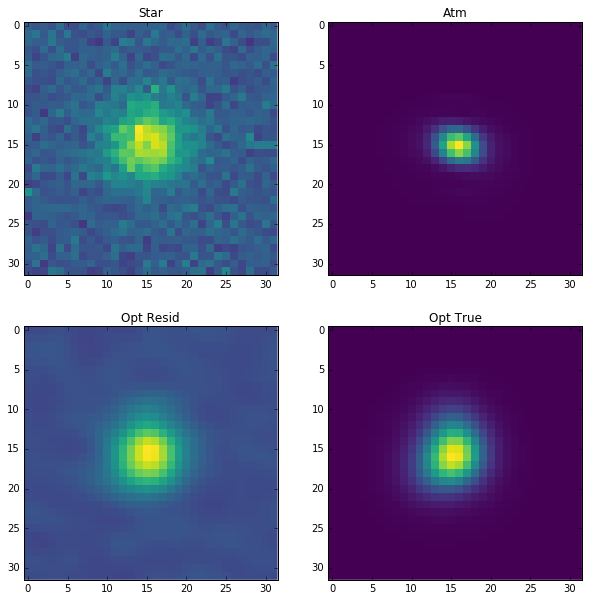

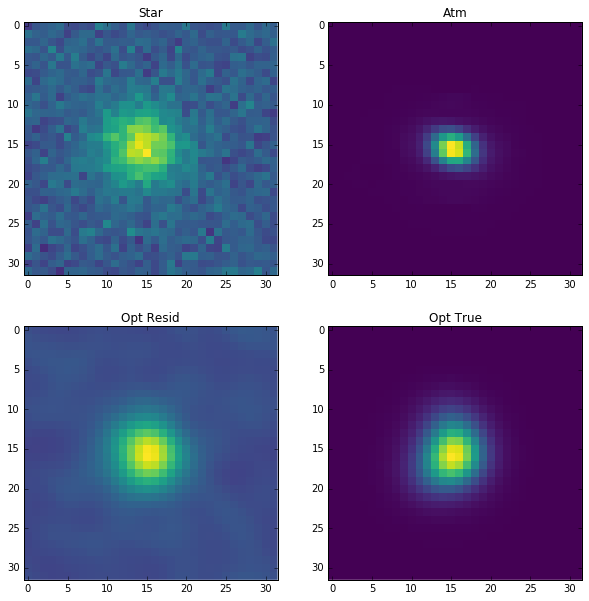

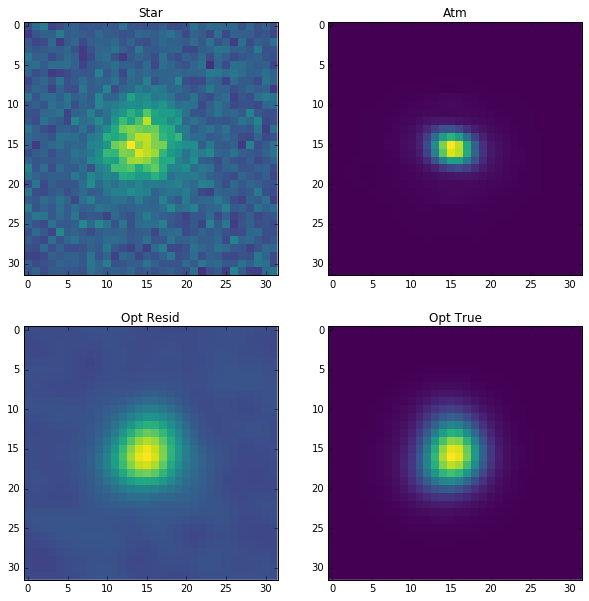

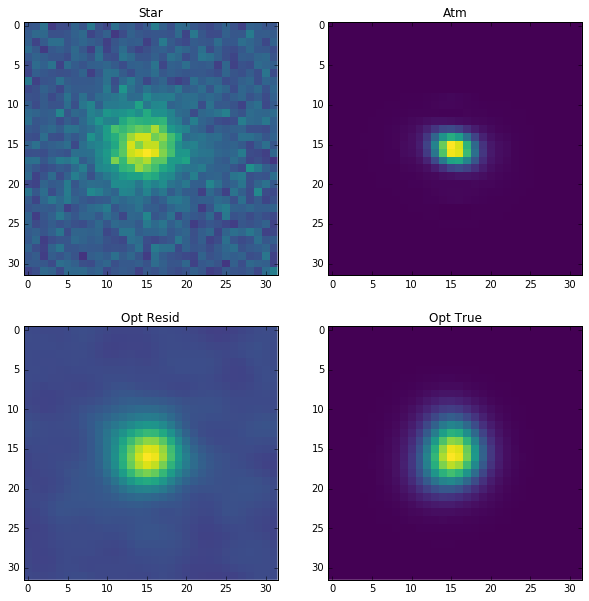

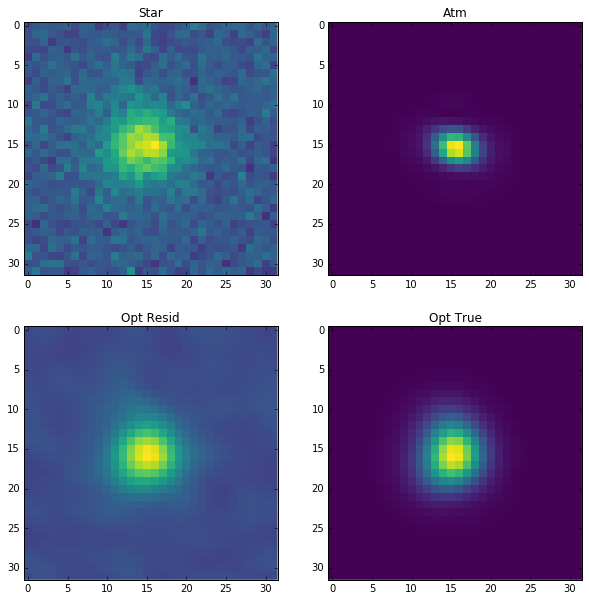

[ 1.25861668  0.41241787  0.36927599]


In [38]:
#6 8 100 bad
#200 good
l = 500#stars.shape[0]
ellip_diffs = np.zeros((l, 3) )
for idx in xrange(l):
    diffs = plot_deconv(idx, alg = 'mine')
    ellip_diffs[idx, :] = diffs
    
print ellip_diffs.mean(axis = 0)

In [20]:
print ellip_diffs.std(axis = 0)

[ 1.41960477  0.70677587  1.20313978]


In [21]:
%%bash
pwd

/afs/slac.stanford.edu/u/ki/swmclau2/Git/DeconvolvePSF
